In [3]:
import json
import pathlib
import sys
from io import StringIO
from IPython.display import display, SVG

import svgwrite
import numpy as np
import pandas as pd

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.util.db_utils import SynFermDatabaseConnection
from src.util.color_palette import BodeColorPalette

In [4]:
from lxml import etree
from lxml.builder import E

In [5]:
con = SynFermDatabaseConnection()

In [8]:
res = con.con.execute('SELECT e.id, r.I_long, r.M_long, r.T_long, r.product_A_smiles, r.reaction_smiles, l.binary_A, l.binary_B, l.binary_C, l.binary_D, l.binary_E, l.binary_F, l.binary_G, l.binary_H, l.scaled_A, l.scaled_B, l.scaled_C, l.scaled_D, l.scaled_E, l.scaled_F, l.scaled_G, l.scaled_H, l."major_A-C" FROM experiments e LEFT JOIN representations r on e.id = r.experiment_id INNER JOIN labels l on e.id = l.experiment_id;').fetchall()

columns = [
    "experiment_id", 
    "I_long", 
    "M_long", 
    "T_long", 
    "product_A_smiles", 
    "reaction_smiles", 
    "binary_A", 
    "binary_B", 
    "binary_C", 
    "binary_D", 
    "binary_E", 
    "binary_F", 
    "binary_G", 
    "binary_H", 
    "scaled_A", 
    "scaled_B", 
    "scaled_C", 
    "scaled_D", 
    "scaled_E", 
    "scaled_F", 
    "scaled_G", 
    "scaled_H", 
    "major_A-C",
]
df = pd.DataFrame(res, columns=columns)

In [9]:
def get_class(series):
    most_frequent_value = series.value_counts().index[0]
    if most_frequent_value == "A":
        return "major-A"
    if most_frequent_value == "B":
        return "major-B"
    if most_frequent_value == "C":
        return "major-C"
    if most_frequent_value == "no_product":
        return "major-none"

In [10]:
x_axis = "Monomer"
y_axis = "Initiator"

In [11]:
x_index = np.sort(df[f"{x_axis[0]}_long"].unique())
y_index = np.sort(df[f"{y_axis[0]}_long"].unique())

In [376]:
# some settings for the plot
rect_x = 20
rect_y = 20
text_len = 80

x_total = len(x_index) * rect_x + text_len
y_total = len(y_index) * rect_y + text_len

# set root
svg = E.svg(viewBox=f"0 0 {x_total} {y_total}")

# set internal CSS styles
style = E.style("""
.major-A {
  fill: blue;
  stroke: darkblue;
}
.major-B {
  fill: orange;
  stroke: darkorange;
}
.major-C {
  fill: green;
  stroke: darkgreen;
}
.major-none {
  fill: red;
  stroke: darkred;
}
.axes {
  stroke: black; 
}
.axes-labels {
  fill: black;
  font-family: Helvetica, Helvetica;
  font-size: 10px;
}
""")
svg.append(style)

# set axes
axes = E.g()
axes.set("class", "axes")
axes.append(E.line(x1=str(text_len), x2=str(x_total), y1=str(y_total - text_len), y2=str(y_total - text_len)))  # x-axis
axes.append(E.line(x1=str(text_len), x2=str(text_len), y1="0", y2=str(y_total - text_len)))  # y-axis
svg.append(axes)

# set axes labels
axes_labels = E.g()
axes_labels.set("class", "axes-labels")
x_labels = E.text(transform=f"translate({text_len} {2 * y_total}) rotate(-90)")
y_labels = E.text(x="0", y=str(rect_y))

# x-axis labels
for i_x, x_label in enumerate(x_index):
    tspan = E.tspan(x_label, y=str((i_x + 0.5) * rect_x), x=str(y_total))
    x_labels.append(tspan)

# y-axis labels
for i_y, y_label in enumerate(y_index):
    tspan = E.tspan(y_label, x="0", y=str((i_y + 0.5) * rect_y))
    y_labels.append(tspan)

# Append the tspan elements
axes_labels.append(x_labels)
axes_labels.append(y_labels)
svg.append(axes_labels)

# set heatmap squares
squares = E.g()

for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            offset_x = rect_x * i_x + text_len
            offset_y = rect_y * i_y
            square = E.rect(x=str(offset_x), y=str(offset_y), width=str(rect_x), height=str(rect_y), id=f"{x}_{y}")
            square.set("class", get_class(data["major_A-C"]))
            squares.append(square)
svg.append(squares)

# render to string
s = etree.tostring(svg, pretty_print=True)

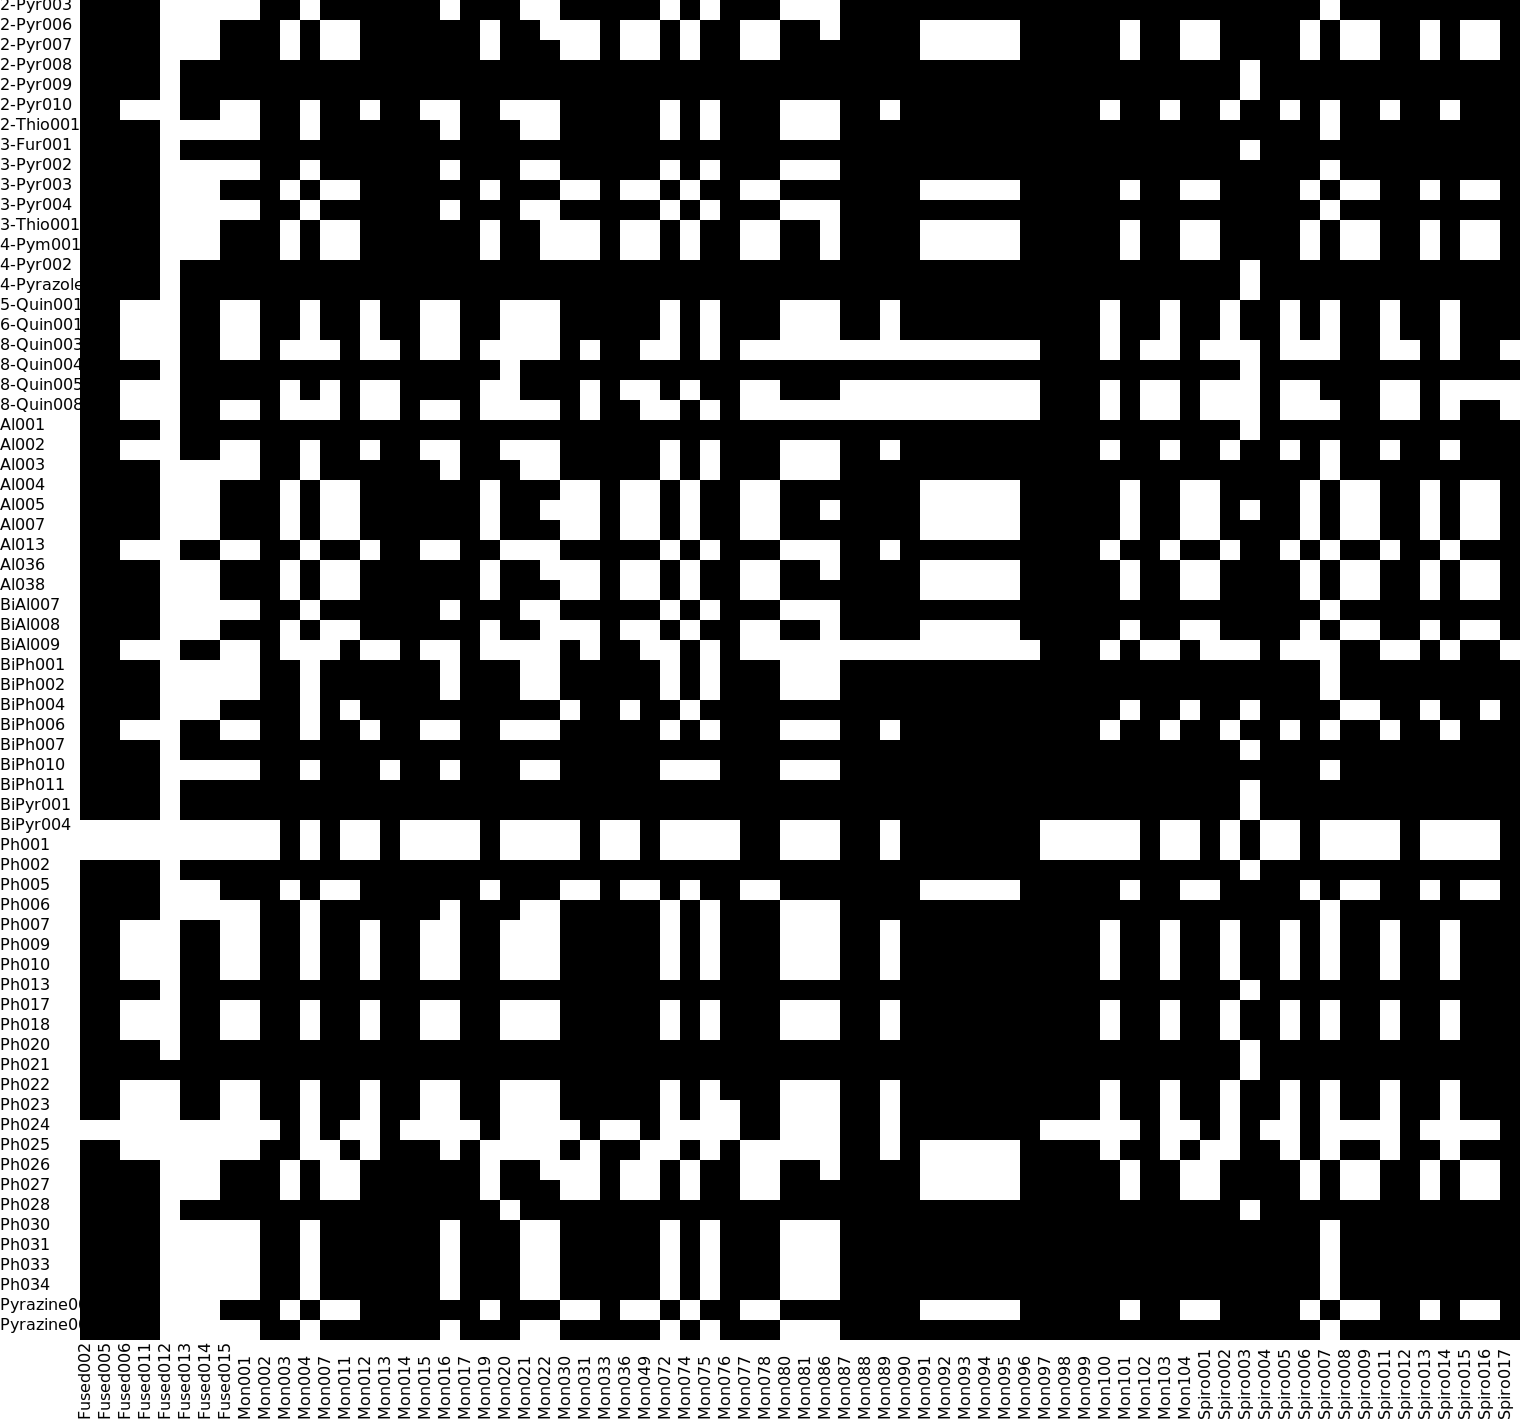

In [377]:
display(SVG(s))

In [378]:
with open("/Users/julian/Desktop/sf_heatmap_majorProduct.svg", "wb") as f:
    f.write(etree.tostring(svg, pretty_print=True))

In [18]:
# we will need a JSON dict to relate identifiers to data points / SVG images
relations = {}
for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        identifier = f"{x}_{y}"
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            filenames = [f"product_images/{row['I_long']}_{row['M_long']}_{row['T_long']}.svg" for i, row in data.iterrows()]
            major = [row['major_A-C'] for i, row in data.iterrows()]
        else:
            filenames = []
            major = {"A": 0, "B": 0, "C": 0, "none":0}
        relations[identifier] = {"filenames": filenames, "major": major}
            

In [21]:
print(relations)

{'Fused002_2-Pyr003': {'filenames': ['product_images/2-Pyr003_Fused002_TerTH005.svg', 'product_images/2-Pyr003_Fused002_TerABT013.svg', 'product_images/2-Pyr003_Fused002_TerTH011.svg', 'product_images/2-Pyr003_Fused002_TerTH014.svg', 'product_images/2-Pyr003_Fused002_TerTH001.svg', 'product_images/2-Pyr003_Fused002_TerTH019.svg', 'product_images/2-Pyr003_Fused002_TerTH025.svg', 'product_images/2-Pyr003_Fused002_TerABT014.svg', 'product_images/2-Pyr003_Fused002_TerABT004.svg', 'product_images/2-Pyr003_Fused002_TerABT007.svg'], 'major': ['B', 'no_product', 'A', 'B', 'B', 'A', 'B', 'A', 'A', 'no_product']}, 'Fused002_2-Pyr006': {'filenames': ['product_images/2-Pyr006_Fused002_TerABT006.svg', 'product_images/2-Pyr006_Fused002_TerABT012.svg', 'product_images/2-Pyr006_Fused002_TerABT016.svg', 'product_images/2-Pyr006_Fused002_TerABT008.svg', 'product_images/2-Pyr006_Fused002_TerABT017.svg', 'product_images/2-Pyr006_Fused002_TerTH021.svg', 'product_images/2-Pyr006_Fused002_TerTH006.svg', 'pro

In [24]:
with open("svg-relations.json", "w") as f:
    json.dump(relations, f)